In [4]:
"""Colab Drive Connection"""

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
import warnings
import os 

from collections import defaultdict
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import networkx as nx
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

import random

from tqdm import tqdm_notebook

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# install datatable
!pip install datatable
import datatable as dt

from numba import njit

import gc

warnings.simplefilter(action="ignore")

# project_home = "/kaggle/input/jane-street-market-prediction"
# data_home = project_home

project_home = "/gdrive/MyDrive/colab/jane-street-market-prediction"
data_home = os.path.join(project_home, "input/data")
model_home = os.path.join(project_home, "output/model")

     |████████████████████████████████| 83.7MB 65kB/s 


In [2]:
entire_seed = 1029

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.deterministic = False
    
seed_torch(entire_seed)

In [5]:
train_file = os.path.join(data_home,'train.csv')
features_file = os.path.join(data_home,'features.csv')
example_test_file = os.path.join(data_home,'example_test.csv')
example_sample_submission_file = os.path.join(data_home,'example_sample_submission.csv')

train_data_datatable = dt.fread(train_file)

df_train = train_data_datatable.to_pandas()
df_features = pd.read_csv(features_file)
df_example_test = pd.read_csv(example_test_file)
df_example_sample_submission = pd.read_csv(example_sample_submission_file)

In [6]:
features = [ col for col in df_train.columns if "feature" in col ]
resps = [ col for col in df_train.columns if "resp" in col ]
target_resp = [resp_ for resp_ in resps if "_" not in resp_]
target = ["weight"] + target_resp + features 

In [7]:
"""
Reduce Memory Usage by 75%
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

## Reduce Memory

def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
#                 reducing float16 for calculating numpy.nanmean
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

df_train = reduce_memory_usage(df_train)
df_train.info()

Memory usage of dataframe is 2489.4869804382324 MB
Memory usage of dataframe after reduction 1247.0233011245728 MB
Reduced by 49.908422461199 % 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(135), int16(1), int32(1), int8(1)
memory usage: 1.2 GB


In [8]:
# drop before 85days
df_train = df_train.loc[df_train.date>85]
# drop weight 0 for training
df_train = df_train.loc[df_train.weight > 0]

# df_labels = df_train[['date','weight','resp_1','resp_2','resp_3','resp_4','resp']]

# df_train = df_train.drop(df_labels.columns,axis=1)

In [9]:
"""
The codes from 'Optimise Speed of Filling-NaN Function'
https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function
"""

def for_loop(method, matrix, values):
    for i in range(matrix.shape[0]):
        matrix[i] = method(matrix[i], values)
    return matrix

def for_loop_ffill(method, matrix):
    tmp = np.zeros(matrix.shape[1],dtype=np.float32)
    for i in range(matrix.shape[0]):
        matrix[i] = method(matrix[i], tmp)
        tmp = matrix[i]
    return matrix

@njit
def fillna_npwhere_njit(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

In [10]:
# converting numpy for efficient calcualtion.
# ft 1~129
np_ft_train = df_train.loc[:,features[1:]].values
np_ft_train.shape

# ft 0
# np_train_ft0 = df_train.loc[:,features[0]].values

(1571415, 129)

In [11]:
f_mean = np.nanmean(np_ft_train,axis=0)

In [12]:
np_train = df_train.values

In [13]:
dict_features = {col:idx for idx, col in enumerate(df_train.columns.tolist())}

In [14]:
print('fillna_npwhere_njit (mean-filling):')
np_train[:,8:-1] = for_loop(fillna_npwhere_njit, np_train[:,8:-1], f_mean)

fillna_npwhere_njit (mean-filling):


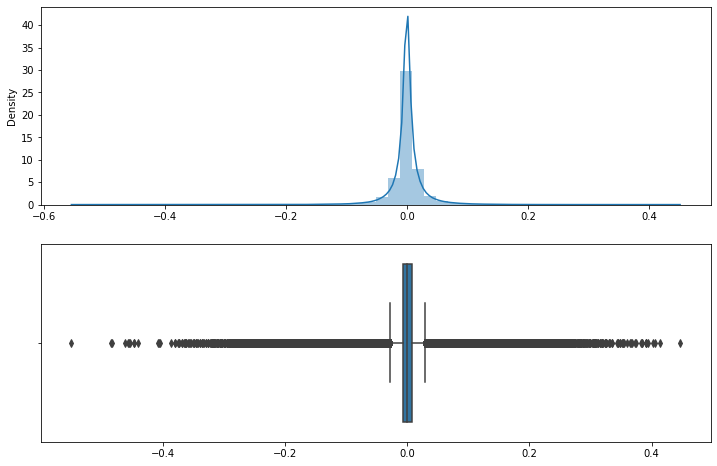

In [15]:
fig, axes = plt.subplots(2,1,figsize=[12,8])

sns.distplot(np_train[:,dict_features["resp"]], ax=axes[0])
sns.boxplot(np_train[:,dict_features["resp"]], ax=axes[1])

In [21]:
# resp_percentiles = [np.percentile(np_train[:,dict_features["resp"]],(i+1)*10) for i in range(10)]

In [22]:
np_d_w = np_train[:,:2]
# ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']
idx_resps = list()
for resp in resps:
    idx_col = dict_features[resp]
    idx_resps.append(idx_col)
np_resps = np_train[:,idx_resps]

# date, weight, resp, ft_0...130
# X_np_train = np_train[:,idx_targets]

In [23]:
def utility_score(X_d_w,X_r,y):
    # X for date, weight, resp numpy.array
    # y for binary action by random threshold or prediction
    
    # date
    date_min, date_max = np.min(X_d_w[:,0]), np.max(X_d_w[:,0])
    period = date_max - date_min + 1
    dates = np.arange(date_min, date_max+1)
    
    list_p = list()
    
    for date in dates:
        idx_date = X_d_w[:,0] == date
        X_d = X_d_w[idx_date,0]
        y_d = y[idx_date]
        w_d = X_d_w[idx_date,1]
        r_d = X_r[idx_date]
        
        p_d = w_d * r_d * y_d
        p = p_d.sum()
        
        list_p.append(p)
    
    np_p = np.array(list_p)
    

    t = np.sum(np_p) / np.sqrt(np.sum(np.power(np_p,2))) * np.sqrt(250/period)
    utility_score = min(max(t,0),6)*np_p.sum()
    return utility_score

In [24]:
def calculate_percentile(np_d_w, np_resps, percentiles):
    X_d_w = np_d_w
    list_best_prcntl = list()
    for i in range(np_resps.shape[1]):
        print(f"{resps[i]} processing...")
        X_r= np_resps[:,i]
        
        best_prcntl = 0
        best_u_score = 0
        
        for prcntl in percentiles:
            threshold = np.percentile(X_r, prcntl)
            y = np.array(list(map(lambda x: 1 if x>threshold else 0, X_r)))
            u_score = utility_score(X_d_w, X_r, y)
            print(f"percentile {prcntl}%; utiliy_score: {u_score:.4f}")
            if u_score > best_u_score:
                best_u_score = u_score
                best_prcntl = prcntl
                
        list_best_prcntl.append((best_prcntl,best_u_score))
    return list_best_prcntl

In [25]:
# list_prcntl = calculate_percentile(np_d_w, np_resps, np.arange(10,100,10))

In [26]:
# list_prcntl

In [27]:
# list_prcntl = calculate_percentile(np_d_w, np_resps, np.arange(45,56,1))

In [28]:
# list_prcntl

In [29]:
# ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']
# [50, 49, 49, 50, 50]
# resps_prcntls = np.array(list(map(lambda x:x[0],list_prcntl)))
resps_prcntls = [50, 49, 49, 50, 50]
resps_prcntls = [np.percentile(np_resps[:,idx], prcntls) for idx, prcntls in enumerate(resps_prcntls)]
resps_prcntls

[2.3540282199974172e-05,
 -2.6968382262566605e-05,
 -6.920687970705338e-05,
 7.239638944156468e-05,
 4.7192643251037225e-05]

In [30]:
list_resps = list()
for idx, resps_prcntl in enumerate(resps_prcntls):
    result = list(map(lambda x: 1 if x > resps_prcntl else 0, np_resps[:,idx]))
    list_resps.append(result)
np_targets = np.stack(list_resps).T

In [31]:
np_targets

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1],
       ...,
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [32]:
idx_target = [("resp_" not in key) and ("ts_" not in key) for key in dict_features.keys()]
idx_target = np.arange(np_train.shape[1])[idx_target]
X_np_train = np_train[:,idx_target]

In [33]:
X = X_np_train
y = np_targets

In [49]:
class JaneDataset(Dataset):
    def __init__(self, np_X, np_y):
        super(JaneDataset,self).__init__()
        self.X = np_X
        self.y = np_y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        # date, weight, resp
        X_util = self.X[index, :3]
        X = torch.tensor(self.X[index, 3:],dtype=torch.float)
        y = torch.tensor(self.y[index],dtype=torch.float)
        return X_util, X, y

In [50]:
dataset = JaneDataset(X, y)

In [51]:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(entire_seed))

In [70]:
dummy = iter(train_dataloader)
dummy2 = next(dummy)

In [71]:
dummy2

[tensor([[ 1.7200e+02,  2.0337e-01, -2.6323e-03],
         [ 4.5800e+02,  2.4289e+00,  3.8558e-02],
         [ 4.9200e+02,  6.2148e-01,  2.0343e-02],
         ...,
         [ 4.7600e+02,  5.8965e+01,  5.5245e-03],
         [ 3.8000e+02,  3.0140e-01,  1.6431e-03],
         [ 1.9800e+02,  9.2621e-01, -9.2365e-03]], dtype=torch.float64),
 tensor([[ 1.0000,  1.3608,  2.3501,  ...,  0.2439, -0.6441,  0.7885],
         [-1.0000, -0.1656,  0.1443,  ...,  1.5192,  0.8002,  1.2989],
         [-1.0000, -1.9024, -1.8638,  ..., -0.4014, -0.1775, -0.1065],
         ...,
         [-1.0000,  0.0787,  0.3850,  ..., -1.1865, -1.6968, -0.8142],
         [ 1.0000, -3.1720, -3.0932,  ..., -0.2104, -2.6794, -0.0905],
         [-1.0000,  2.1394,  4.8889,  ..., -0.1211, -0.0960, -0.1908]]),
 tensor([[0., 0., 0., 1., 0.],
         [0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         ...,
         [0., 1., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.]])]

In [73]:
X_d_w = dummy2[0].detach().cpu().numpy()

X_r = X_d_w[:,-1]
X_d_w = X_d_w[:,:-1]
y = dummy2[2].detach().cpu().numpy()[:,-1]

utility_score(X_d_w,X_r,y)

457.2947453065417

In [ ]:
utility_score()

In [52]:
class ResidualBlock(nn.Module):
    expansion: int=1
    def __init__(self, inplane, plane, stride=1, dilation=1, dropout=0.2, downsample=None):
        super(ResidualBlock,self).__init__()
        
        self.conv1 = self.conv3x3(inplane, plane, stride, dilation)
        self.bn1 = nn.BatchNorm1d(plane)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = self.conv3x3(plane, plane)
        self.bn2 = nn.BatchNorm1d(plane)
        
        # Inplace means in Activation Func
        # https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948
        self.relu = nn.ReLU(inplace=False)
        
        self.downsample = downsample
        
    def conv3x3(self, in_planes, out_planes, stride=1, dilation=1):
        return nn.Conv1d(in_planes, out_planes, 3, stride, padding=dilation, bias=False)
        
    def forward(self, x):
        shortcut = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            shortcut = self.downsample(x)
            
        out += shortcut
        out = self.relu(out)
        
        return out

In [53]:
from typing import Type, Any, Callable, Union, List, Optional

class CustomResNet(nn.Module):
    def __init__(self, block: Type[ResidualBlock], layers: List[int], dropout=0.2, num_feature=130, hidden_layers=[512,256], num_classes: int = 5):
        super(CustomResNet, self).__init__()
        self.inplanes = 64
        self.block = block
        self.dropout = dropout
        self.num_feature = num_feature
        self.h1, self.h2 = hidden_layers
        self.num_classes = num_classes
        self.reshaped_dim = int(self.h1 / self.inplanes)

        self.relu = nn.ReLU(inplace=False)
        
        self.bn_d0 = nn.BatchNorm1d(self.num_feature)
        self.dropout_d0 = nn.Dropout(self.dropout)
        
        self.dense1 = nn.Linear(self.num_feature, self.h1)
        self.bn_d1 = nn.BatchNorm1d(self.h1)
        self.dropout_d1 = nn.Dropout(self.dropout)

        self.layer1 = self.make_layers(self.block,64, layers[0], stride=1)
        self.layer2 = self.make_layers(self.block,128,layers[1], stride=2)
        self.layer3 = self.make_layers(self.block,256,layers[2], stride=2)
        # self.layer4 = self.make_layers(self.block,512,layers[3], stride=2)
 
        self.avgpool = nn.AvgPool1d(2)
        self.flt = nn.Flatten()

        self.dense2 = nn.Linear(int(self.h1/2), self.h2)
        self.bn_d2 = nn.BatchNorm1d(self.h2)
        self.dropout_d2 = nn.Dropout(self.dropout)
    
        self.dense3 = nn.Linear(self.h2, self.num_classes)
        

    def make_layers(self, block, planes, layer, stride=1):
        downsample = None
        
        if stride > 1:
            downsample = nn.Sequential(
                self.conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm1d(planes * block.expansion),
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=1,dropout=self.dropout, downsample=downsample))
        self.inplanes = planes * block.expansion

        for i in range(layer-1):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
            
 
    def conv1x1(self, in_planes, out_planes, stride=1):
        return nn.Conv1d(in_planes, out_planes, 1, stride=stride, bias=False)

    def forward(self, x):
        
        x = self.bn_d0(x)
        x = self.dropout_d0(x)

        x = self.dense1(x)
        x = self.bn_d1(x)
        x = self.relu(x)
        x = self.dropout_d1(x)

        x = x.reshape(x.size(0), 64, self.reshaped_dim)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)

        x = self.flt(x)

        x = self.dense2(x)
        x = self.bn_d2(x)
        x = self.relu(x)
        x = self.dropout_d2(x)

        x = self.dense3(x)

        return x
        

In [54]:
block = ResidualBlock
model = CustomResNet(block=block, layers=[3,4,4], hidden_layers=[512,128])

In [55]:
epochs = 100
batch_size = 4096
learning_rate = 1e-3
weight_decay = 1e-5

In [56]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [59]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [60]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score: #  + self.delta
            self.counter += 1
            # print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            # ema.apply_shadow()
            self.save_checkpoint(epoch_score, model, model_path)
            # ema.restore()
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(f"Validation score improved ({self.val_score:.4f} --> {epoch_score:.4f}). Saving model!")
            # if not DEBUG:
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [ ]:
NFOLDS = 1
EARLYSTOP_NUM = 7
CACHE_PATH = model_home

for _fold in range(NFOLDS):
    print(f'Fold{_fold}:')
    seed_torch(seed=entire_seed+_fold)
    torch.cuda.empty_cache()
    model = CustomResNet(block=block, layers=[3,4,4], hidden_layers=[512,128])
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    es = EarlyStopping(EARLYSTOP_NUM, mode="max")
    for epoch in tqdm_notebook(range(epochs)):

        running_loss = 0.0
        running_acc = 0.0
        running_auc = 0.0
        running_util = 0.0

        model.train()
        
        for idx, (X_utils,inputs, labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad()

            X_d_w = X_utils[:,:-1].detach().cpu().numpy()
            X_r = X_utils[:,-1].detach().cpu().numpy()

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            true = labels.detach().cpu().numpy()[:,-1]
            target = np.array(list(map(lambda x: 1 if x > 0.5 else 0, outputs.sigmoid().detach().cpu().numpy()[:,-1])),dtype=np.float)
            
            acc = (true == target).sum() / outputs.shape[0]
            auc = roc_auc_score(true, outputs.detach().cpu().numpy()[:,-1])
            util = utility_score(X_d_w,X_r,target)
    
            running_acc += acc
            running_auc += auc
            running_util += util

            loss = criterion(outputs,labels)
            running_loss += loss.detach().item() * inputs.size(0)
            loss.backward()
            optimizer.step()
            
        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_acc / len(train_dataloader)
        epoch_auc = running_auc / len(train_dataloader)
        epoch_util = running_util

        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_acc = 0.0
            running_auc = 0.0
            running_util = 0.0

            for idx, (X_utils, inputs, labels) in enumerate(valid_dataloader):

                X_d_w = X_utils[:,:-1].detach().cpu().numpy()
                X_r = X_utils[:,-1].detach().cpu().numpy()

                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                true = labels.detach().cpu().numpy()[:,-1]
                target = np.array(list(map(lambda x: 1 if x > 0.5 else 0, outputs.sigmoid().detach().cpu().numpy()[:,-1])),dtype=np.float)
                
                acc = (true == target).sum() / outputs.shape[0]
                auc = roc_auc_score(true, outputs.detach().cpu().numpy()[:,-1])
                util = utility_score(X_d_w,X_r,target)

                running_acc += acc
                running_auc += auc
                running_util += util

                loss = criterion(outputs, labels)
                running_loss += loss.detach().item() * inputs.size(0)
                
            valid_loss = running_loss / len(valid_dataloader.dataset)
            valid_acc = running_acc / len(valid_dataloader)
            valid_auc = running_auc / len(valid_dataloader)
            valid_util = running_util

        print(f"EPOCH:{epoch+1}|{epochs}; loss(train/valid):{epoch_loss:.4f}/{valid_loss:.4f}; acc(train/valid):{epoch_acc:.4f}/{valid_acc:.4f}; auc(train/valid):{epoch_auc:.4f}/{valid_auc:.4f}; utility(train/valid):{epoch_util:.4f}/{valid_util:.4f}")
        
        model_weights = os.path.join(model_home,f"U_resnet_64_3-128_4-256_4_{_fold}.pth")
        es(valid_util, model, model_path=model_weights)
        if es.early_stop:
          print("Early stopping")
          break

Fold0:


EPOCH:1|100; loss(train/valid):0.6924/0.6895; acc(train/valid):0.5145/0.5209; auc(train/valid):0.5219/0.5341; utility(train/valid):1477.4173/378.4918
Validation score improved (-inf --> 378.4918). Saving model!
EPOCH:2|100; loss(train/valid):0.6900/0.6886; acc(train/valid):0.5209/0.5257; auc(train/valid):0.5311/0.5370; utility(train/valid):2100.8065/470.0132
Validation score improved (378.4918 --> 470.0132). Saving model!
EPOCH:3|100; loss(train/valid):0.6892/0.6882; acc(train/valid):0.5226/0.5253; auc(train/valid):0.5339/0.5389; utility(train/valid):2380.1510/435.7718
EPOCH:4|100; loss(train/valid):0.6887/0.6880; acc(train/valid):0.5233/0.5267; auc(train/valid):0.5354/0.5406; utility(train/valid):2430.8055/511.2570
Validation score improved (470.0132 --> 511.2570). Saving model!
EPOCH:5|100; loss(train/valid):0.6885/0.6877; acc(train/valid):0.5238/0.5274; auc(train/valid):0.5368/0.5409; utility(train/valid):2644.8526/539.6113
Validation score improved (511.2570 --> 539.6113). Saving m